# Analyst Exercise
### Evelyn Cheng
#### June 23, 2019

### 1. Perform any necessary data cleaning and quality control to get the data ready for analysis.

In [7]:
# Include matplotlib plots within jupyter notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Import csv data as dataframe
eof_df = pd.DataFrame.from_csv('data/DATA.csv', index_col=None)

# Replace the '#VALUE!' strings with NaN's
eof_df = eof_df.replace('#VALUE!', np.nan)

# Convert fieldID into categorical datatype and OrganicN into float64
eof_df["fieldID"] = eof_df["fieldID"].astype('object')
eof_df["OrganicN"] = eof_df["OrganicN"].astype('float')

# Delete last 5 columns which are nonsense
eof_df = eof_df.drop(['Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14','Unnamed: 15'], axis=1)

# Delete last 1300 rows
eof_df = eof_df[:-1300]

In [ ]:
# Replace all negative numbers with NaN's, because even if it were theoretically possible to have 
# negative values for the nutrient additions, it's highly unlikely, especially given these
# wildly outlier-negative numbers.

eof_df["OrganicN"] = np.where(eof_df["OrganicN"] >= 0, eof_df["OrganicN"], np.nan)
eof_df["NO3"] = np.where(eof_df["NO3"] >= 0, eof_df["NO3"], np.nan)
eof_df["OrganicP"] = np.where(eof_df["OrganicP"] >= 0, eof_df["OrganicP"], np.nan)
eof_df["SolubleP"] = np.where(eof_df["SolubleP"] >= 0, eof_df["SolubleP"], np.nan)
eof_df["Sediment"] = np.where(eof_df["Sediment"] >= 0, eof_df["Sediment"], np.nan)

# Delete 16 rows for fields #4737 and #4738 because area can't equal 0
eof_df = eof_df[eof_df.area != 0]

# Take all of the zeros out of the fieldID's
eof_df.fieldID = eof_df.fieldID.apply(lambda x: str(x).replace('.0', ''))

In [ ]:
# Since the values for OrganicN appear to roughly follow the same trends as those of NO3, OrganicP, SolubleP, 
# and Sediment, the ideal imputation method to use for the NaN OrganicN values might be kNN clustering. 
# However, because I'm just going to be comparing means of treatment groups, for now I'm going to use 
# the "quick and dirty" method of filling the NaN values with the mean value of the column.
eof_df.fillna(eof_df.mean(), inplace=True);

In [ ]:
# Visually inspect plots of nutrient levels for outliers
eof_df.plot.scatter(x='fieldID', y='OrganicN')
eof_df.plot.scatter(x='fieldID', y='NO3')
eof_df.plot.scatter(x='fieldID', y='OrganicP')
eof_df.plot.scatter(x='fieldID', y='SolubleP')
eof_df.plot.scatter(x='fieldID', y='Sediment')

# Zoomed in
eof_df.plot.scatter(x='fieldID', y='area').set_ylim((0,20))

In [ ]:
# NOTE:
# field 4967 has 8 extra rows from duplicated scenarios which have no data. 
# Recommended action: delete extra rows

# 4710 & 4717 each have 4 extra rows for scenarios involving drip irrigation (in addition to flood and sprinkler irrigation). 
# Recommended action: leave them in for now

eof_df.groupby(['fieldID']).size().sort_values(ascending=False).head()

In [ ]:
# Delete the duplicate rows for field 4967 which have a value of "0" for sediment
eof_df = eof_df.drop(eof_df[(eof_df['Sediment'] == 0) & (eof_df['fieldID'] == 4967)].index)

In [ ]:
# Save munged dataset as new csv file
eof_df.to_csv("eof_clean.csv", encoding='utf8')

### 2. Create two new columns, one for total phosphorus (OrganicP + SolubleP) and another for total nitrogen (OrganicN + NO3).

In [ ]:
df = pd.DataFrame.from_csv('eof_clean.csv')

In [ ]:
df['TotalP'] = df['OrganicP'] + df['SolubleP']
df['TotalN'] = df['OrganicN'] + df['NO3']

In [9]:
updf = pd.DataFrame.from_csv('data/eof_totals_2.csv', index_col=None)
updf.head()

,fieldID,irrigation,buffer,fence,treatment,scenario_type,area,OrganicN,NO3,OrganicP,SolubleP,Sediment,TotalP,TotalN
0,4686,flood_irr,buff_none,no_fence,flo,current condition,3.61749,16.971480,5.329404,2.262886,2.447538,16.526993,4.710425,22.300884
1,4686,flood_irr,buff_none,fenced,flo_fence,alternative,3.61749,3.591848,1.127916,0.478918,0.517997,3.497776,0.996915,4.719764
2,4686,flood_irr,buffer,no_fence,flo_buff,alternative,3.61749,3.626385,1.094963,0.483523,0.483523,3.531409,0.967046,4.721348
3,4686,flood_irr,buffer,fenced,flo_buff_fence,alternative,3.61749,3.453700,1.042822,0.460498,0.460498,3.363246,0.920996,4.496522
4,4686,sprinkler_irr,buff_none,no_fence,spr,alternative,3.61749,6.535846,1.898646,0.829990,0.897717,6.697331,1.727706,8.434491


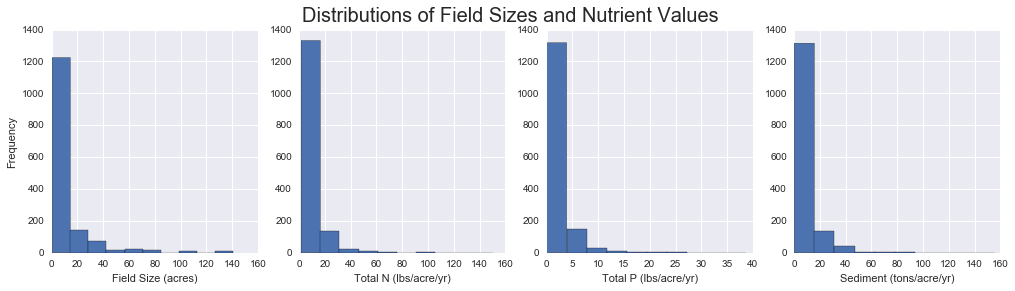

In [10]:
# Check for normal distributions, to determine which statistical tests may be used.
# Current scenario sediments are very skewed to the right (not a perfectly normal distribution)
# Areas are similarly skewed. We will want to log transform these data for some analyses.

fig, axs = plt.subplots(1,4,figsize=(17,4))
fig.suptitle('Distributions of Field Sizes and Nutrient Values', size=20)

axs[0].hist(updf['area'])
axs[1].hist(updf['TotalN'])
axs[2].hist(updf['TotalP'])
axs[3].hist(updf['Sediment'])
axs[0].set_xlabel('Field Size (acres)')
axs[1].set_xlabel('Total N (lbs/acre/yr)')
axs[2].set_xlabel('Total P (lbs/acre/yr)')
axs[3].set_xlabel('Sediment (tons/acre/yr)')
axs[0].set_ylabel('Frequency')
plt.show()

In [11]:
from numpy.random import seed
from numpy.random import randn
from numpy import exp
from scipy.stats import boxcox
from matplotlib import pyplot
import math

updf_t = updf
updf_t['log_area'] = updf["area"].apply(np.log)
updf_t['log_sediment'] = updf["Sediment"].apply(np.log)
updf_t['log_totalN'] = updf["TotalN"].apply(np.log)
updf_t['log_totalP'] = updf["TotalP"].apply(np.log)
updf_t=updf_t = updf_t.drop(['scenario_type','area','OrganicN','NO3','OrganicP','SolubleP','Sediment','TotalP','TotalN'], axis=1)

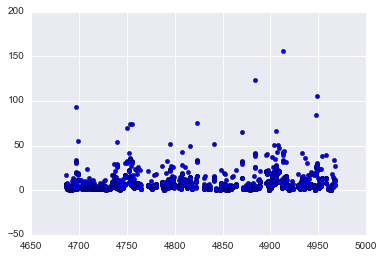

In [12]:
# Compare scatterplots for sediment and log-transformed sediment
plt.scatter(x=updf['fieldID'],y=updf['Sediment'])

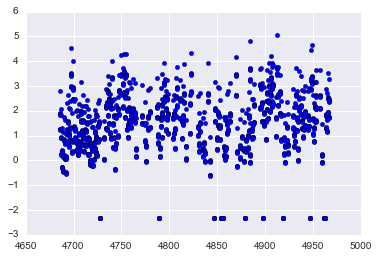

In [13]:
plt.scatter(x=updf_t['fieldID'],y=updf_t['log_sediment'])

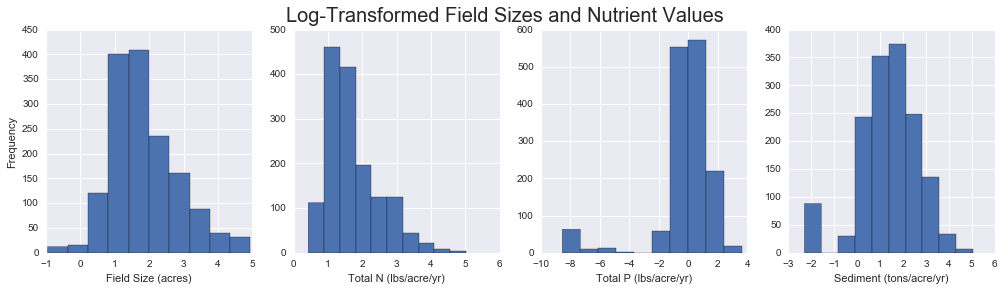

In [14]:
# Distributions look much more normal after log transformation
fig, axs = plt.subplots(1,4,figsize=(17,4))
fig.suptitle('Log-Transformed Field Sizes and Nutrient Values', size=20)

axs[0].hist(updf_t['log_area'])
axs[1].hist(updf_t['log_totalN'])
axs[2].hist(updf_t['log_totalP'])
axs[3].hist(updf_t['log_sediment'])
axs[0].set_xlabel('Field Size (acres)')
axs[1].set_xlabel('Total N (lbs/acre/yr)')
axs[2].set_xlabel('Total P (lbs/acre/yr)')
axs[3].set_xlabel('Sediment (tons/acre/yr)')
axs[0].set_ylabel('Frequency')
plt.show()

In [15]:
# Distributions look more normally-distributed; save as new csv file
updf_t.to_csv("log_eof_totals.csv", encoding='utf8')

### 3. Calculate the “uplift” for total nitrogen, total phosphorus, and sediment by finding the difference between the current condition runoff values and each alternative for each field 
(i.e., what is the change in runoff under each suite of management actions for every field?). 

Note: pay attention to units – both “per acre” and “per field” runoff values can be important and insightful, depending on the situation.

In [16]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline

In [17]:
sdf = pd.DataFrame.from_csv('data/log_sediment.csv', index_col=None)
ndf = pd.DataFrame.from_csv('data/log_totaln.csv', index_col=None)
pdf = pd.DataFrame.from_csv('data/log_totalp.csv', index_col=None)

In [18]:
sdf2 = pd.pivot_table(sdf,index=["fieldID","area"], columns="treatment", values="Sediment", aggfunc='first')
ndf2 = pd.pivot_table(ndf,index=["fieldID","area"], columns="treatment", values="TotalN", aggfunc='first')
pdf2 = pd.pivot_table(pdf,index=["fieldID","area"], columns="treatment", values="TotalP", aggfunc='first')

In [19]:
# Calculate per field uplift for Sediment, TotalN, and TotalP (NOT normalized)
# Subtract treatment value from current value, to keep uplift values positive
# store values in three "_df2" dataframes.

sdf2['up_flo_buff']=sdf2['flo']-sdf2['flo_buff']
sdf2['up_flo_buff_fence']=sdf2['flo']-sdf2['flo_buff_fence']
sdf2['up_flo_fence']=sdf2['flo']-sdf2['flo_fence']
sdf2['up_spr']=sdf2['flo']-sdf2['spr']
sdf2['up_spr_buff']=sdf2['flo']-sdf2['spr_buff']
sdf2['up_spr_buff_fence']=sdf2['flo']-sdf2['spr_buff_fence']
sdf2['up_spr_fence']=sdf2['flo']-sdf2['spr_fence']
sdf2.drop(sdf2.columns[[0,1,2,3,4,5,6,7]], axis=1, inplace=True)
s_up_df=sdf2.reset_index(level='area')
# s_up_df.to_csv("log_sed_uplift.csv", encoding='utf8')

ndf2['up_flo_buff']=ndf2['flo']-ndf2['flo_buff']
ndf2['up_flo_buff_fence']=ndf2['flo']-ndf2['flo_buff_fence']
ndf2['up_flo_fence']=ndf2['flo']-ndf2['flo_fence']
ndf2['up_spr']=ndf2['flo']-ndf2['spr']
ndf2['up_spr_buff']=ndf2['flo']-ndf2['spr_buff']
ndf2['up_spr_buff_fence']=ndf2['flo']-ndf2['spr_buff_fence']
ndf2['up_spr_fence']=ndf2['flo']-ndf2['spr_fence']
ndf2.drop(ndf2.columns[[0,1,2,3,4,5,6,7]], axis=1, inplace=True)
n_up_df=ndf2.reset_index(level='area')
# n_up_df.to_csv("log_n_uplift.csv", encoding='utf8')

pdf2['up_flo_buff']=pdf2['flo']-pdf2['flo_buff']
pdf2['up_flo_buff_fence']=pdf2['flo']-pdf2['flo_buff_fence']
pdf2['up_flo_fence']=pdf2['flo']-pdf2['flo_fence']
pdf2['up_spr']=pdf2['flo']-pdf2['spr']
pdf2['up_spr_buff']=pdf2['flo']-pdf2['spr_buff']
pdf2['up_spr_buff_fence']=pdf2['flo']-pdf2['spr_buff_fence']
pdf2['up_spr_fence']=pdf2['flo']-pdf2['spr_fence']
pdf2.drop(pdf2.columns[[0,1,2,3,4,5,6,7]], axis=1, inplace=True)
p_up_df=pdf2.reset_index(level='area')
# p_up_df.to_csv("log_p_uplift.csv", encoding='utf8')

### 4. Show your findings (assume your target audience is other TFT analysts).

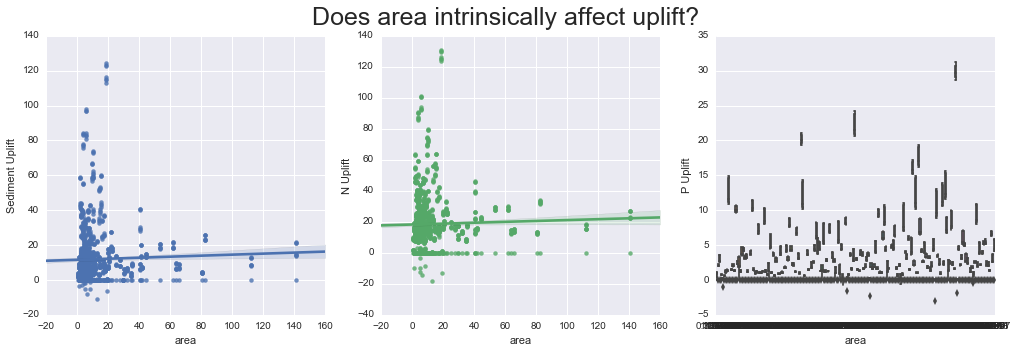

In [20]:
# Check if the area of the field has any intrinsic relationship with uplift; 
# i.e. Does having a bigger field cause less sediment and nutrient runoff? Doesn't look like it.
updf2 = pd.DataFrame.from_csv('uplift_all.csv', index_col=None)
fig, axs = plt.subplots(ncols=3, figsize=(17, 5), sharey=False)
fig.suptitle('Does area intrinsically affect uplift?', size=25)
sns.regplot(x="area", y="sed_up", data=updf2, ax=axs[0])
sns.regplot(x="area", y="N_up", data=updf2, ax=axs[1])
sns.boxplot(x="area", y="P_up", data=updf2, ax=axs[2])
axs[0].set_ylabel('Sediment Uplift')
axs[1].set_ylabel('N Uplift')
axs[2].set_ylabel('P Uplift')

### *Check pairwise relationships between all uplift values; find that they all increase together*

In [62]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

upmoddf = pd.DataFrame.from_csv('uplift_all.csv', index_col=None)

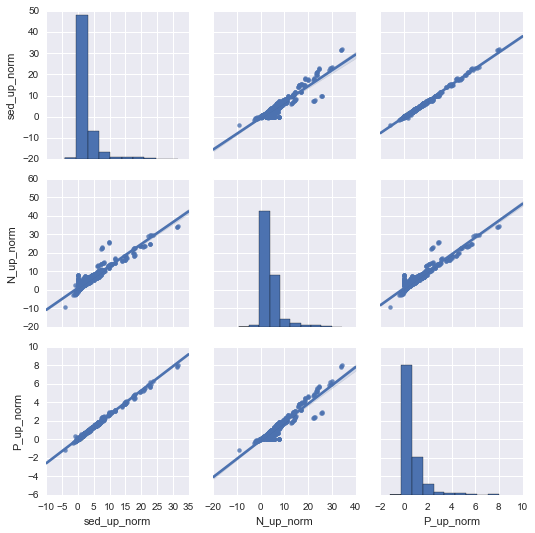

In [63]:
import seaborn
seaborn.pairplot(upmoddf, vars=['sed_up_norm', 'N_up_norm', 'P_up_norm'], kind='reg')

### *Performing an ANOVA test on linear models, to better understand how each of the BMP scenarios influence mean sediment uplift*

In [77]:
model1 = smf.ols("sed_up ~ irrigation", upmoddf).fit()
model2 = smf.ols("sed_up ~ buffer", upmoddf).fit()
model3 = smf.ols("sed_up ~ fence", upmoddf).fit()
model4 = smf.ols("sed_up ~ irrigation + buffer", upmoddf).fit()
model5 = smf.ols("sed_up ~ irrigation + fence", upmoddf).fit()
model6 = smf.ols("sed_up ~ buffer + fence", upmoddf).fit()
model7 = smf.ols("sed_up ~ irrigation + buffer + fence", upmoddf).fit()
model8 = smf.ols("sed_up ~ irrigation + irrigation*buffer", upmoddf).fit()
model9 = smf.ols("sed_up ~ irrigation + irrigation*fence", upmoddf).fit()
model10 = smf.ols("sed_up ~ irrigation + irrigation*buffer*fence", upmoddf).fit() ####
model11 = smf.ols("sed_up ~ irrigation + buffer*fence", upmoddf).fit()
model12 = smf.ols("sed_up ~ buffer + irrigation*buffer", upmoddf).fit()
model13 = smf.ols("sed_up ~ buffer + irrigation*fence", upmoddf).fit()
model14 = smf.ols("sed_up ~ buffer + irrigation*buffer*fence", upmoddf).fit() ####
model15 = smf.ols("sed_up ~ buffer + buffer*fence", upmoddf).fit()
model16 = smf.ols("sed_up ~ fence + irrigation*buffer", upmoddf).fit()
model17 = smf.ols("sed_up ~ fence + irrigation*fence", upmoddf).fit()
model18 = smf.ols("sed_up ~ fence + irrigation*buffer*fence", upmoddf).fit() ####
model19 = smf.ols("sed_up ~ fence + buffer*fence", upmoddf).fit()
model20 = smf.ols("sed_up ~ irrigation + buffer + fence + irrigation*buffer + irrigation*fence + fence*buffer + irrigation*buffer*fence", upmoddf).fit() ####


In [78]:
aiclist=[model1.aic, model2.aic, model3.aic, model4.aic, model5.aic, model6.aic, model7.aic, model8.aic, 
         model9.aic, model10.aic, model11.aic, model12.aic, model13.aic, model14.aic, model15.aic, model16.aic, 
         model17.aic, model18.aic, model19.aic, model20.aic]

modsdf = pd.DataFrame(aiclist)
modindex = list(range(1,21))
modsdf['modelnum'] = modindex
modsdf.sort_values(by=[0])

,0,modelnum
9,12530.910635,10
17,12530.910635,18
13,12530.910635,14
19,12530.910635,20
10,12591.186531,11
18,12591.581707,19
14,12591.581707,15
15,12594.004977,16
12,12594.066875,13
6,12613.169498,7


### All of the best-fit models factor in the interactions between the three BMP's: sprinkler irrigation, an edge-of-field buffer, and/or a livestock exclusion fence

#### With p < 0.00001, we can be confident that there is a significant difference in the mean sediment runoff of the different treatments. Less than 1% of the variation in runoff can be explained by this model, so the fit is super crappy. Basically none of these models are a good fit for our data. Perhaps this is because we need to collect more data and measure more factors?

In [79]:
# Summary statistics for one of the best-fit models
model20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sed_up   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     14.52
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           5.30e-27
Time:                        00:23:56   Log-Likelihood:                -6253.5
No. Observations:                1512   AIC:                         1.253e+04
Df Residuals:                    1500   BIC:                         1.259e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          0.8731     10.744      0.081      0.935       -20.202    21.948
irrigation[T.flood_irr]                                           14.8133     10.801      1.371      0.170        -6.373    36.000
irrigation[T.sprinkler_irr]                                       11.3683     10.801      1.053      0.293        -9.818    32.555
buffer[T.buffer]                                                   0.0667     15.194      0.004      0.996       -29.738    29.871
fence[T.no_fence]                                                 -0.0867     15.194     -0.006      0.995       -29.891    29.718
irrigation[T.flood_irr]:buffer[T.buffer]                           0.0974     15.275      0.006      0.995       -29.865    30.060
irrigation[T.sprinkler_irr]:buffer[T.buffer]                       0.1931     15.275      0.013      0.990       -29.770    30.156
irrigation[T.flood_irr]:fence[T.no_fence]                        -15.7987     15.275     -1.034      0.301       -45.761    14.164
irrigation[T.sprinkler_irr]:fence[T.no_fence]                     -0.3070     15.275     -0.020      0.984       -30.270    29.656
fence[T.no_fence]:buffer[T.buffer]                                 0.0033     21.488      0.000      1.000       -42.147    42.153
irrigation[T.flood_irr]:buffer[T.buffer]:fence[T.no_fence]        15.6770     21.602      0.726      0.468       -26.697    58.051
irrigation[T.sprinkler_irr]:buffer[T.buffer]:fence[T.no_fence]     0.0789     21.602      0.004      0.997       -42.295    42.453
==============================================================================
Omnibus:                     1072.382   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16041.585
Skew:                           3.206   Prob(JB):                         0.00
Kurtosis:                      17.613   Cond. No.                         200.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# Type 2 ANOVA
aov = sm.stats.anova_lm(model10, typ=3)
print(aov)
aov = sm.stats.anova_lm(model14, typ=3)
print(aov)
aov = sm.stats.anova_lm(model18, typ=3)
print(aov)
aov = sm.stats.anova_lm(model20, typ=3)
print(aov)

                                sum_sq      df             F        PR(>F)
Intercept                     1.524691     1.0  6.604095e-03  9.352416e-01
irrigation                 1456.528446     2.0  3.154426e+00  4.294604e-02
buffer                        0.004445     1.0  1.925199e-05  9.964997e-01
fence                         0.007512     1.0  3.253586e-05  9.954496e-01
irrigation:buffer             0.451759     2.0  9.783817e-04  9.990221e-01
irrigation:fence          11344.195615     2.0  2.456830e+01  3.170728e-11
buffer:fence                  0.000006     1.0  2.406499e-08  9.998762e-01
irrigation:buffer:fence    5748.414533     2.0  1.244943e+01  4.341750e-06
Residual                 346305.905520  1500.0           NaN           NaN
                                sum_sq      df             F        PR(>F)
Intercept                     1.524691     1.0  6.604095e-03  9.352416e-01
buffer                        0.004445     1.0  1.925199e-05  9.964997e-01
irrigation               

### *There is a statistically significant difference between sediment runoffs from flood-irrigated and sprinkler-irrigated fields (without buffers or fences)*

In [21]:
# Calculate mean sediment, N, and P uplift for all flood-irrigated fields and sprinkler-irrigated fields combined.
# Store these normalized-by-area values in three "x_irr_df" dataframes

sed_irr_df=s_up_df
sed_irr_df['up_mean_flo'] = (sed_irr_df[['up_flo_buff','up_flo_buff_fence','up_flo_fence']].mean(axis=1))/ s_up_df['area']
sed_irr_df['up_mean_spr'] = (sed_irr_df[['up_spr','up_spr_buff','up_spr_buff_fence','up_spr_fence']].mean(axis=1))/ s_up_df['area']

n_irr_df=n_up_df
n_irr_df['up_mean_flo'] = (n_irr_df[['up_flo_buff','up_flo_buff_fence','up_flo_fence']].mean(axis=1))/ n_up_df['area']
n_irr_df['up_mean_spr'] = (n_irr_df[['up_spr','up_spr_buff','up_spr_buff_fence','up_spr_fence']].mean(axis=1))/ n_up_df['area']

p_irr_df=p_up_df
p_irr_df['up_mean_flo'] = (p_irr_df[['up_flo_buff','up_flo_buff_fence','up_flo_fence']].mean(axis=1))/ p_up_df['area']
p_irr_df['up_mean_spr'] = (p_irr_df[['up_spr','up_spr_buff','up_spr_buff_fence','up_spr_fence']].mean(axis=1))/ p_up_df['area']

In [61]:
alldf = pd.DataFrame.from_csv('data/eof_totals_2_norm.csv', index_col=None)
flood = alldf[alldf['treatment']=='flo']
sprinkler = alldf[alldf['treatment']=='spr']

In [28]:
# Paired t-test to compare mean sediment runoff from flood-irrigated fields and sprinkler-irrigated fields
print("mean Sediment runoff for flood-irrigated fields (no buffer or fence): ", np.mean(flood['sed_norm']))
print("mean Sediment runoff for sprinkler-irrigated fields: ", np.mean(sprinkler['sed_norm']))
print(stats.ttest_rel(flood['sed_norm'], sprinkler['sed_norm']))

mean Sediment runoff for flood-irrigated fields (no buffer or fence):  3.8415622361914874
mean Sediment runoff for sprinkler-irrigated fields:  1.5446339416223407
Ttest_relResult(statistic=9.4847902960601562, pvalue=1.1375759029237392e-17)


In [29]:
# Paired t-test to compare mean N runoff from flood-irrigated fields and sprinkler-irrigated fields
print("mean Sediment runoff for flood-irrigated fields (no buffer or fence): ", np.mean(flood['N_norm']))
print("mean Sediment runoff for sprinkler-irrigated fields: ", np.mean(sprinkler['N_norm']))
print(stats.ttest_rel(flood['N_norm'], sprinkler['N_norm']))

mean Sediment runoff for flood-irrigated fields (no buffer or fence):  5.513087553085104
mean Sediment runoff for sprinkler-irrigated fields:  1.3743583802925534
Ttest_relResult(statistic=13.120068638596369, pvalue=2.6492736010217825e-28)


In [30]:
# Paired t-test to compare mean P runoff from flood-irrigated fields and sprinkler-irrigated fields
print("mean Sediment runoff for flood-irrigated fields (no buffer or fence): ", np.mean(flood['P_norm']))
print("mean Sediment runoff for sprinkler-irrigated fields: ", np.mean(sprinkler['P_norm']))
print(stats.ttest_rel(flood['P_norm'], sprinkler['P_norm']))

mean Sediment runoff for flood-irrigated fields (no buffer or fence):  1.0176579251595748
mean Sediment runoff for sprinkler-irrigated fields:  0.3696036306755319
Ttest_relResult(statistic=10.084322900088397, pvalue=2.2604901435817742e-19)


### *The following barplot illustrates the drastic difference in runoff between flood- and sprinkler-irrigated plots.*

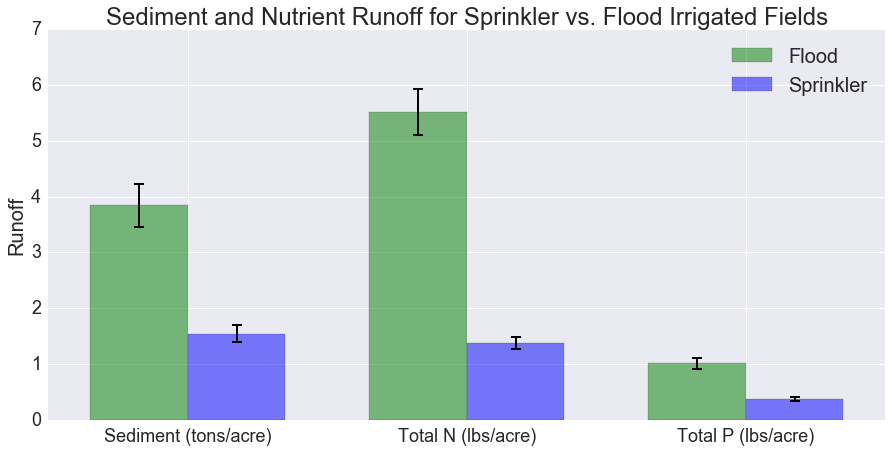

In [81]:
# Plot the pre-transformed per-acre data in barplots with std error bars
# Note: the axis ticks are not scaled correctly for sediment and N / P; this plot is just to illustrate the 
# statistically significant differences
alldf = pd.DataFrame.from_csv('data/eof_totals_2_norm.csv', index_col=None)
flood = alldf[alldf['treatment']=='flo']
sprinkler = alldf[alldf['treatment']=='spr']

labels = ['Sediment (tons/acre)', 'Total N (lbs/acre)','Total P (lbs/acre)']

flood_sed_mean = np.mean(flood.sed_norm)
flood_sed_sem = stats.sem(flood.sed_norm)
flood_N_mean = np.mean(flood.N_norm)
flood_N_sem = stats.sem(flood.N_norm)
flood_P_mean = np.mean(flood.P_norm)
flood_P_sem = stats.sem(flood.P_norm)
sprinkler_sed_mean = np.mean(sprinkler.sed_norm)
sprinkler_sed_sem = stats.sem(sprinkler.sed_norm)
sprinkler_N_mean = np.mean(sprinkler.N_norm)
sprinkler_N_sem = stats.sem(sprinkler.N_norm)
sprinkler_P_mean = np.mean(sprinkler.P_norm)
sprinkler_P_sem = stats.sem(sprinkler.P_norm)

flood_means, flood_ste = (flood_sed_mean, flood_N_mean, flood_P_mean), (flood_sed_sem, flood_N_sem, flood_P_sem)
spr_means, spr_ste = (sprinkler_sed_mean, sprinkler_N_mean, sprinkler_P_mean), (sprinkler_sed_sem, sprinkler_N_sem, sprinkler_P_sem)

ind = np.arange(len(flood_means))
width = 0.35 

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(ind - width/2, flood_means, width, yerr=flood_ste, align='center',alpha=0.5,
                label='Flood', color='g',error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))
rects2 = ax.bar(ind + width/2, spr_means, width, yerr=spr_ste, align='center', alpha=0.5,
                label='Sprinkler', color='b', error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))

ax.set_ylabel('Runoff', size=20)
ax.set_title('Sediment and Nutrient Runoff for Sprinkler vs. Flood Irrigated Fields', size=24)
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.set_ylim(0,7)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(prop={'size': 20})

In [51]:
sdf = pd.DataFrame.from_csv('data/uplift_sed_norm.csv', index_col=None)
ndf = pd.DataFrame.from_csv('data/uplift_N_norm.csv', index_col=None)
pdf = pd.DataFrame.from_csv('data/uplift_P_norm.csv', index_col=None)

In [52]:
sdf2 = pd.pivot_table(sdf,index=["fieldID","area"], columns="treatment", values="sed_up_norm", aggfunc='first')
ndf2 = pd.pivot_table(ndf,index=["fieldID","area"], columns="treatment", values="N_up_norm", aggfunc='first')
pdf2 = pd.pivot_table(pdf,index=["fieldID","area"], columns="treatment", values="P_up_norm", aggfunc='first')

In [53]:
# Uplift has already been calculated; just need to drop the nonapplicable columns
# These "x_up_df" dataframes list uplift values per field (i.e. not per acre)

sdf2.drop(sdf2.columns[[0,1,2,3]], axis=1, inplace=True)
s_up_df=sdf2.reset_index(level='area')
# s_up_df.to_csv("uplift_sed_pivot.csv", encoding='utf8')

ndf2.drop(ndf2.columns[[0,1,2,3]], axis=1, inplace=True)
n_up_df=ndf2.reset_index(level='area')
# n_up_df.to_csv("uplift_n_pivot.csv", encoding='utf8')

pdf2.drop(pdf2.columns[[0,1,2,3]], axis=1, inplace=True)
p_up_df=pdf2.reset_index(level='area')
# p_up_df.to_csv("uplift_p_pivot.csv", encoding='utf8')

In [54]:
# These "xdf_up_norm" dataframes include uplift values, normalized by dividing by area
sdf_up_norm = s_up_df.iloc[:,1:].div(s_up_df.area, axis=0)
ndf_up_norm = n_up_df.iloc[:,1:].div(n_up_df.area, axis=0)
pdf_up_norm = s_up_df.iloc[:,1:].div(s_up_df.area, axis=0)

### *The following 3 boxplots indicate that there is not a statistically significant difference between BMP's, beyond switching from flood irrigation to sprinkler irrigation*

### Sediment uplift (tons/acre/year) by treatment

"flo" indicates the default/current scenario of flood irrigation with no buffer or fence.

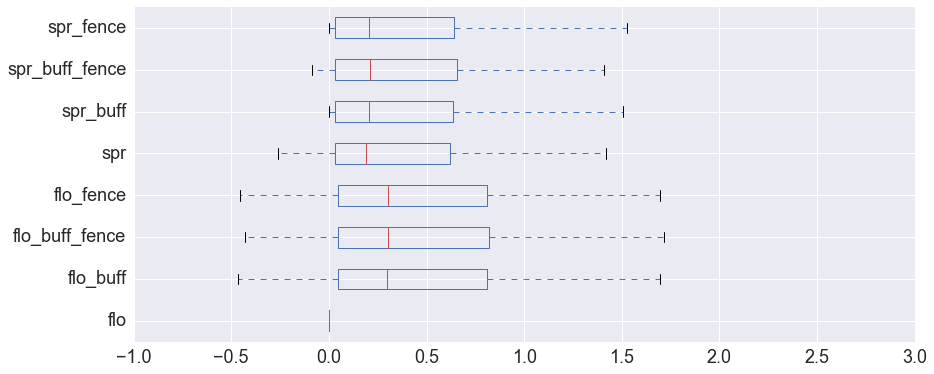

In [100]:
sd_box = sdf_up_norm.plot.box(vert=False, figsize=(14,6), fontsize=18).set_xlim([-1,3])

### Total N uplift (lbs/acre/year) by treatment

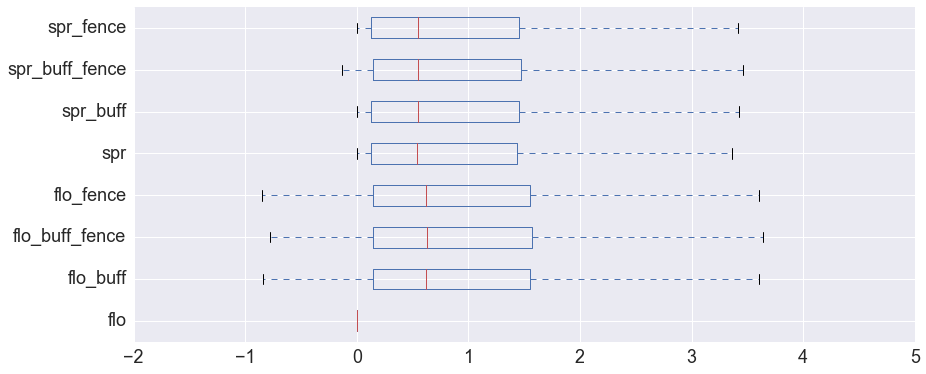

In [88]:
n_box = ndf_up_norm.plot.box(vert=False, figsize=(14,6), fontsize=18).set_xlim([-2,5])

### Total P uplift (lbs/acre/year) by treatment

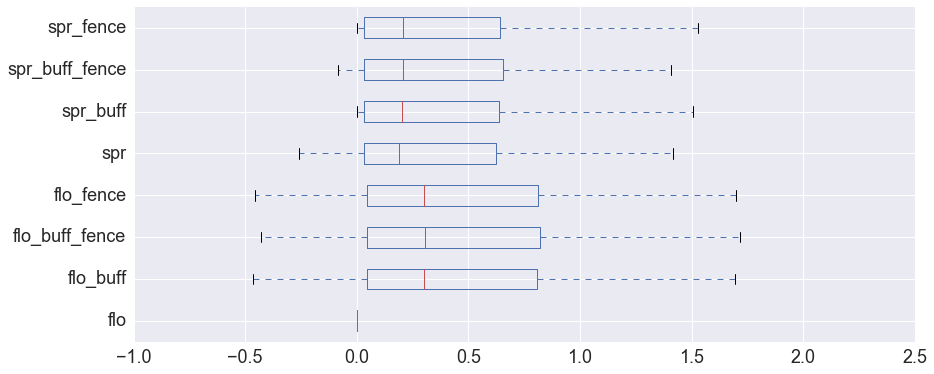

In [89]:
p_box = pdf_up_norm.plot.box(vert=False, figsize=(14,6), fontsize=18).set_xlim([-1,2.5])

## Conclusion

If you are able to change from flood to sprinkler irrigation, then that would be the most effective first step to take for limiting sediment and nutrient runoff. Flood irrigation also shows the most improvement (i.e. uplift) when you add in a buffer, a fence, or both. There's ultimately not that significant of a difference between those BMP's, so you might want to look at which option is the most practical and/or financially sensible for your particular field.

Sprinkler-irrigated fields have much less runoff in general, but they also respond much less dramatically to buffers and fences than flood-irrigated fields do. This is why flood-irrigated fields exhibit the greatest uplift values and thus provide the greatest "bang for your buck".

A side note: Larger fields (i.e. 10 or more acres) have less runoff in general. 

A qualifying statement: As the exercise instructions state that this was intended to be a mock dataset, I am pretending that these data were taken from the real world (i.e. not generated by a model), and I still would want to do some more exploratory data analysis before attempting to build or select my own model of the data, fit it to a particular set of conditions, and validate it. If I were trying to go the build-my-own-model route, I'd also keep in mind that these data are likely not enough to generate a model that could be employed in practical situations. There are many other variables missing, such as soil type, vegetation, aspect, slope, time, historical land use, livestock, etc. 